 **Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services**

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [160]:
# import libraries here; add more as necessary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ast

import time
import pickle

# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.utils import resample

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score


# magic word for producing visualizations in notebook
%matplotlib inline

## Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# # load in the data
# azdias = pd.read_csv(r'..\data\Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'})
# customers = pd.read_csv(r'..\data\Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})

In [3]:
# # Saving datatsets as pickle to speed up loading next time
# azdias.to_pickle('azdias.pickle')
# customers.to_pickle('customers.pickle')

In [4]:
# Loading pickle datasets
azdias = pd.read_pickle('azdias.pickle')
customers = pd.read_pickle('customers.pickle')

### Reading in Datasets (AZDIAS & CUSTOMERS)

**AZDIAS** Dataset

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226.0,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241.0,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(360), object(6)
memory usage: 2.4+ GB


In [7]:
azdias.shape

(891221, 366)

**CUSTOMERS** Dataset

In [8]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [10]:
customers.shape

(191652, 369)

## DATA PREPROCESSING

Preprocessing the AZDIAS Dataset

### Comparing features in AZDIAS, CUSTOMER and DIAS

Exploring 'DIAS Attributes - Values 2017.xlsx'. There's 4 columns: **['Attribute', 'Description', 'Value', 'Meaning']**

Will perform some data cleaning and compare all the features here with the features in AZDIAS and CUSTOMES datasets

In [11]:
# Loading DIAS Attributes Values 2017.xlsx
attributes_values = pd.read_excel('../DIAS Attributes - Values 2017.xlsx', header=1)

In [12]:
attributes_values.head(3)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly


In [13]:
attributes_values = attributes_values[attributes_values.columns[1:]]
attributes_values = attributes_values[attributes_values['Attribute'].notnull()]
print('attributes_values | Data shape (rows, cols): ', attributes_values.shape)


attributes_values | Data shape (rows, cols):  (314, 4)


In [14]:
azdias_features_exclusive = list(set(azdias) - set(attributes_values['Attribute'].tolist()))
print('Number of features present only in Azdias: ', len(azdias_features_exclusive), '\n')

Number of features present only in Azdias:  94 



In [15]:
customers_features_exclusive = set(customers) - set(azdias)
print('Number of features present only in customers: ', len(customers_features_exclusive), '\n')
print(customers_features_exclusive)


Number of features present only in customers:  3 

{'ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP'}


There are 3 additional features in CUSTOMERS compared with AZDIAS: ['ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP']
we need to take this difference into consideration in further analysis.

###  Addressing unknown values

The main idea in this step is to address the unknown values. In the attributes-values dataframe, unknown records are represented by one or multiple numerical values. These unknown values should be treated as missing entries.  So, let's find these unknowns values and change them to NaN values in AZDIAS dataset.

In [16]:
# check the meaning of first values pre attributes
set(attributes_values['Meaning'].tolist())

{'Event travelers',
 'Universal',
 'Work-Life-Balance',
 'building is located in a 125 x 125m-grid cell (RA1), which is a consumption cell',
 'business cell',
 "doesn't belong to the green avantgarde",
 'highest activity within the last 12 months',
 'low-income earners',
 'mainly 1-2 family homes',
 'no Online-transactions within the last 12 months',
 'no transaction known',
 'no transactions known',
 'none',
 'numeric value',
 'numeric value (typically coded from 1-10)',
 'numeric value (typically coded from 1-3)',
 'single ',
 'single low-income earners of younger age',
 'single low-income- and average earners of younger age ',
 'typical low-income earners',
 'unknown',
 'unknown / no main age detectable',
 'very high mobility',
 'very low',
 'very low car quote'}

In [17]:
unknown = attributes_values[attributes_values['Meaning'].isin(['unknown','unknown / no main age detectable'])]
set(unknown['Meaning'].tolist())

{'unknown', 'unknown / no main age detectable'}

In [18]:
for column in azdias.columns:
    if azdias[column].dtype == np.int64:
        azdias[column] = azdias[column].astype(np.float64)
    if column not in set(unknown['Attribute']):
        continue
    unknown_value = unknown.loc[unknown['Attribute']==column].Value.item()
    unknown_valuen = set(float(x) for x in unknown_value.split(', ')) if type(unknown_value) is str else set([float(unknown_value)])
    azdias[column] = azdias[column].mask(azdias[column].isin(unknown_valuen), other=np.nan)

In [19]:
print('AZDIAS|Data shape (rows, cols): ', azdias.shape)

AZDIAS|Data shape (rows, cols):  (891221, 366)


In [20]:
azdias.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0


### Exploring missing values column-wise and row-wise

At this point, all unknowns values have been replaced with NaN values. But there's still many missing values.  Therefore, text next step we are going to do is to deal with this missing values

**i) Let's start with analyzing how many missing values each column has.**

In [21]:
percent_missing_col = azdias.isnull().mean() * 100
percent_missing_col

LNR                      0.000000
AGER_TYP                76.019640
AKT_DAT_KL               8.247000
ALTER_HH                34.813699
ALTER_KIND1             90.904837
                          ...    
WOHNDAUER_2008           8.247000
WOHNLAGE                10.451729
ZABEOTYP                 0.000000
ANREDE_KZ                0.000000
ALTERSKATEGORIE_GROB     0.000000
Length: 366, dtype: float64

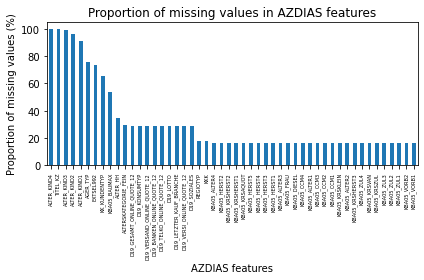

In [22]:
missing_value_col_df = pd.DataFrame({'column_name': azdias.columns,
                                 'percent_missing': percent_missing_col})
# sort the missing percentage
missing_value_col_df.sort_values('percent_missing', ascending=False, inplace=True)
# plot percent of missing values for the first 50 columns
missing_value_col_df[:50].plot(x='column_name', y='percent_missing', kind="bar", legend=False)
plt.xlabel('AZDIAS features')
plt.ylabel('Proportion of missing values (%)')
plt.title('Proportion of missing values in AZDIAS features')
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tight_layout()

The figure above displays which column contains missing values and the percentage of them in that column.
There are many missing values in the dataset, especially eight features having more than 60% missing values.
To figure out a threshold for dropping columns, we can plot number of columns at different percentage of missing values

Text(0.5, 1.0, 'Proportion of missing values in AZDIAS features')

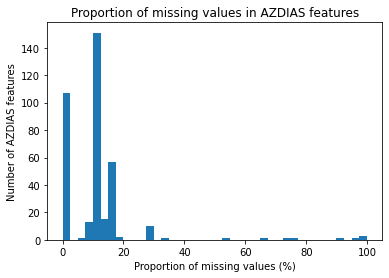

In [23]:
plt.hist(percent_missing_col, bins=40);

plt.xlabel('Proportion of missing values (%)')
plt.ylabel('Number of AZDIAS features')
plt.title('Proportion of missing values in AZDIAS features')

1.The histogram above shows the number of columns for the proportion of missing values.

2.Most of the columns have percentage of missing values of less than 20%. 

**I decided we can take 20% as the cut-off**

In [24]:
columns_to_drop = percent_missing_col[percent_missing_col > 20].index

columns_to_drop

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX',
       'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [25]:
azdias.drop(labels=columns_to_drop, axis=1, inplace=True)

In [26]:
print('AZDIAS|Data shape (rows, cols): ', azdias.shape)

AZDIAS|Data shape (rows, cols):  (891221, 346)


**ii) Let's start with analyzing how many missing values each row has.**

In [27]:
percent_missing_row = azdias.isnull().mean(axis=1) * 100

In [28]:
percent_missing_row


0         68.786127
1          0.000000
2          0.000000
3          1.156069
4          0.000000
            ...    
891216     1.734104
891217     1.156069
891218     0.578035
891219     0.000000
891220     0.000000
Length: 891221, dtype: float64

Text(0.5, 1.0, 'Proportion of missing values in AZDIAS rows')

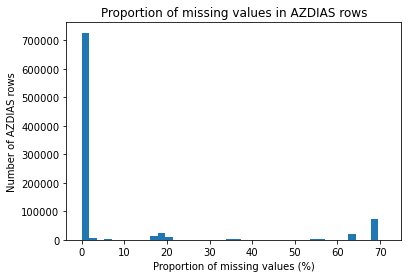

In [29]:
plt.hist(percent_missing_row, bins=40);

plt.xlabel('Proportion of missing values (%)')
plt.ylabel('Number of AZDIAS rows')
plt.title('Proportion of missing values in AZDIAS rows')

1.The histogram above shows the number of rows for the proportion of missing values.

2.Most of the columns have percentage of missing values of less than 10%. However, there are also a high number of rows with missing values greater than 60%.

**I decide to drop any rows that have over 10% missing values.**

In [30]:
azdias = azdias[percent_missing_row <= 10]

In [31]:
print('AZDIAS|Data shape (rows, cols): ', azdias.shape)

AZDIAS|Data shape (rows, cols):  (737287, 346)


### Encoding categorical and mixed features

Some columns in the AZDIAS dataset contain categorical values. Some other may include mixed types. To prepare these for feature extraction, we'll want to convert these into numerical values.

#### Exploring categorical features

In [32]:
# find out columns with the type as object
# azdias.agg(['nunique'])
azdias_object_cols = azdias.columns[azdias.dtypes == "object"]

In [33]:
for col in azdias_object_cols:
    print(col, ': ', len(azdias[col].unique()), 'values, ', azdias[col].unique())

CAMEO_DEU_2015 :  46 values,  ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
CAMEO_DEUG_2015 :  11 values,  ['8' '4' '2' '6' '1' '9' '7' '5' '3' nan 'X']
CAMEO_INTL_2015 :  23 values,  ['51' '24' '12' '43' '54' '22' '14' '13' '15' '41' '34' '55' '33' '25' nan
 '23' '31' '52' '45' '35' '44' '32' 'XX']
EINGEFUEGT_AM :  2819 values,  ['1992-02-10 00:00:00' '1992-02-12 00:00:00' '1997-04-21 00:00:00' ...
 '1994-10-24 00:00:00' '2000-03-09 00:00:00' '2005-03-19 00:00:00']
OST_WEST_KZ :  2 values,  ['W' 'O']


From the 5 object columns, we know that the exist binary, multi-level and mixed categorical varibales as well as mixed features.

Although there are 2819 values in EINGEFUEGT_AM, it seems that it should be in datetime type.

We may consider treating 'X' and 'XX' as NAN values

In [34]:
# change the type of EINGEFUEGT_AM to be datetime
azdias["EINGEFUEGT_AM"] = pd.to_datetime(azdias["EINGEFUEGT_AM"])
azdias["EINGEFUEGT_AM"] = azdias['EINGEFUEGT_AM'].map(lambda x: x.year)

print('EINGEFUEGT_AM: ', len(azdias["EINGEFUEGT_AM"].unique()), \
      'values, ', azdias["EINGEFUEGT_AM"].unique())

EINGEFUEGT_AM:  15 values,  [1992 1997 1995 1996 2005 2004 2000 1994 1993 2003 1999 2001 1998 2002
 1991]


In [35]:
# treat 'X' and 'XX' as nan values
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X', np.nan)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX', np.nan)

# change str to float
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)

In [36]:
print('CAMEO_DEUG_2015: ', len(azdias["CAMEO_DEUG_2015"].unique()), \
      'values, ', azdias["CAMEO_DEUG_2015"].unique())
print('CAMEO_INTL_2015: ', len(azdias["CAMEO_INTL_2015"].unique()), \
      'values, ', azdias["CAMEO_INTL_2015"].unique())

CAMEO_DEUG_2015:  10 values,  [ 8.  4.  2.  6.  1.  9.  7.  5.  3. nan]
CAMEO_INTL_2015:  22 values,  [51. 24. 12. 43. 54. 22. 14. 13. 15. 41. 34. 55. 33. 25. nan 23. 31. 52.
 45. 35. 44. 32.]


**1. Re-encode binary categorical variables**

For binary categorical variables that have non-numerical values, we need to convert them to numerical data.

'OST_WEST_KZ' is the binary categorical variable that should be converted to numerical values. According to DIAS Attributes - Values 2017.xlsx, O represents East (GDR) whereas W stands for West (FRG).

In [37]:
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 0, 'O': 1})

**b. Drop multi-level categorical variables**

For multi-level categorical varaibles, they may incearease the number of features for modeling. Therfore, we may consider dropping them.

In [38]:
# drop categorical variables with more than 10 values
azdias.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis=1, inplace=True)

In [39]:
azdias.shape

(737287, 344)

**c. Convert mixed features to numerical vlaues**

There exist 4 mixed features, including CAMEO_INTL_2015, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB and PRAEGENDE_JUGENDJAHRE. For these, we need to split them into multiple single-type features.

Let's first take a look at CAMEO_INTL_2015. From DIAS Attributes - Values 2017.xlsx, we can find that CAMEO_INTL_2015 (CAMEO_DEUINTL_2015 in attributes-values) can be split into two features, wealth level and status.

CAMEO_INTL_2015 can be re-encoded as the following.

**Status**

1: Pre-Family Couples & Singles

2: Young Couples With Children

3: Families With School Age Children

4: Older Families & Mature Couples

5: Elders In Retirement)

**Wealth Level**

1: Wealthy

2: Prosperous

3: comfortable

4: less affluent

5: poorer

In [40]:
# split CAMEO_INTL_2015
azdias['CAMEO_INTL_2015_WEALTH_LEVEL'] = azdias['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
azdias['CAMEO_INTL_2015_STATUS'] = azdias['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

# drop CAMEO_INTL_2015
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [41]:
azdias.shape

(737287, 345)

LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB are another two mixed features. Among the six columns that start with LP, there are duplicated information and we might need to do some additional data cleaning.

In [42]:
print('LP_LEBENSPHASE_FEIN: ', len(azdias["LP_LEBENSPHASE_FEIN"].unique()), \
      'values, ', azdias["LP_LEBENSPHASE_FEIN"].unique())

print('LP_LEBENSPHASE_GROB: ', len(azdias["LP_LEBENSPHASE_GROB"].unique()), \
      'values, ', azdias["LP_LEBENSPHASE_GROB"].unique())

print('LP_STATUS_FEIN: ', len(azdias["LP_STATUS_FEIN"].unique()), \
      'values, ', azdias["LP_STATUS_FEIN"].unique())

print('LP_STATUS_GROB: ', len(azdias["LP_STATUS_GROB"].unique()), \
      'values, ', azdias["LP_STATUS_GROB"].unique())

print('LP_FAMILIE_FEIN: ', len(azdias["LP_FAMILIE_FEIN"].unique()), \
      'values, ', azdias["LP_FAMILIE_FEIN"].unique())

print('LP_FAMILIE_GROB: ', len(azdias["LP_FAMILIE_GROB"].unique()), \
      'values, ', azdias["LP_FAMILIE_GROB"].unique())

LP_LEBENSPHASE_FEIN:  42 values,  [21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 20.  1. 25. 13. 18. 31. 38. 35.
 30.  7. 22. 29. 24. 28. 37. 26. 12. 39. 27. 36.  9. 14. 34. 33. 15. nan
 11. 40. 16. 19. 23. 17.]
LP_LEBENSPHASE_GROB:  14 values,  [ 6.  1.  0. 10.  2.  3.  5.  7. 12. 11.  9.  8.  4. nan]
LP_STATUS_FEIN:  11 values,  [ 2.  3.  9.  4.  1. 10.  8.  5.  6.  7. nan]
LP_STATUS_GROB:  6 values,  [ 1.  2.  4.  5.  3. nan]
LP_FAMILIE_FEIN:  13 values,  [ 5.  1.  0. 10.  2.  7. 11.  8.  4.  6. nan  9.  3.]
LP_FAMILIE_GROB:  7 values,  [ 3.  1.  0.  5.  2.  4. nan]


Columns LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_FAMILIE_FEIN and LP_FAMILIE_GROB have 0 as one category. However, 0 should not be included according to DIAS Attributes - Values 2017.xlsx. Therefore, any 0s in the four columns will be converted into nan.

If we further look into DIAS Attributes - Values 2017.xlsx, we will find that LP_FAMILIE_GROB and LP_STATUS_GROB are broderer categorization of LP_FAMILIE_FEIN and LP_STATUS_FEIN, respectively. Since each pair contains the same information and the two fine categorizations have over 10 values, LP_FAMILIE_FEIN and LP_STATUS_FEIN will be dropped. Similarly, both LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN will be dropped since they are complex mixed-features.

LP_STATUS_GROB and LP_FAMILIE_GROB can be re-encoded as the following.

**LP_STATUS_GROB:**

Social status

1: low-income earners

2: average earners

3: independants

4: houseowners

5: top earners

**LP_FAMILIE_GROB:**

Family type

1: single

2: couple

3: single parent

4: family

5: multiperson household

In [43]:
# lp is short for LP_*
def encode_lp(df):
    """
    Re-encode LP_* columns:
    - replace 0s with nan values
    - drop complex and/or duplicate columns
    - split columns with mixed features.
    """
    # replace 0s with nan values
    cols = ["LP_LEBENSPHASE_FEIN","LP_LEBENSPHASE_GROB", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB"]
    df[cols] = df[cols].replace({0: np.nan})
    
    # drop complex and/or duplicate columns
    df.drop(['LP_FAMILIE_FEIN','LP_STATUS_FEIN','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    # re-encode LP_STATUS_GROB and LP_FAMILIE_GROB
    status = {1: 1, 2: 1, 3: 2, 
              4: 2, 5: 2, 6: 3, 
              7: 3, 8: 4, 9: 4, 
              10: 5}
    familie = {1: 1, 2: 2, 3: 3, 
               4: 3, 5: 3, 6: 4, 
               7: 4, 8: 4, 9: 5, 
               10: 5, 11: 5}
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(status)                                              
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(familie)    
    
    return df

In [44]:
azdias = encode_lp(azdias)

In [45]:
azdias.shape

(737287, 341)

The 4th mixed-feature column is PRAEGENDE_JUGENDJAHRE. This feature takes unknown values being -1 and 0 and known values ranging from 1 to 15 and. It represents two types of donimating movements in the person's youth.

We can re-encode this feature to contain two values being Mainstream and Avantgarde, respectively.

In [46]:
print('PRAEGENDE_JUGENDJAHRE: ', len(azdias["PRAEGENDE_JUGENDJAHRE"].unique()), \
      'values, ', azdias["PRAEGENDE_JUGENDJAHRE"].unique())

PRAEGENDE_JUGENDJAHRE:  16 values,  [14. 15.  8.  3. 10. 11.  9.  6.  4. nan  5.  2.  1. 12. 13.  7.]


In [47]:
# pj is short for PRAEGENDE_JUGENDJAHRE
def encode_pj(val):
    """
    Re-encode PRAEGENDE_JUGENDJAHRE:
    0: Mainstream
    1: Avantgarde
    """
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    if val in mainstream: 
        return 0
    elif val in avantgarde: 
        return 1
    else:
        return val

In [48]:
azdias['PRAEGENDE_JUGENDJAHRE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))

In [49]:
# check values in column PRAEGENDE_JUGENDJAHRE
print('PRAEGENDE_JUGENDJAHRE: ', len(azdias["PRAEGENDE_JUGENDJAHRE"].unique()), \
      'values, ', azdias["PRAEGENDE_JUGENDJAHRE"].unique())

PRAEGENDE_JUGENDJAHRE:  3 values,  [ 0.  1. nan]


In [50]:
azdias.shape

(737287, 341)

**Droping highly correlated features**

We will be implementing feature correlation to determine too high-correlated features since they many over-inflate the importance of a single feature. 

I decided that features having correlations higher than 0.9 should be dropped

In [51]:
# Running de correlation calculations.  This step can take a while to finish depending on the machine.
corr_matrix = azdias.corr().abs().round(2)

In [52]:
corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            col = corr_matrix.columns[i]
            corr_features.add(col)

In [53]:
print('Number of too highly correlated features: ', len(corr_features))
print(corr_features)

Number of too highly correlated features:  15
{'D19_VERSAND_DATUM', 'KBA13_KMH_250', 'ORTSGR_KLS9', 'CAMEO_INTL_2015_WEALTH_LEVEL', 'KBA13_HALTER_66', 'PLZ8_ANTG1', 'ANZ_STATISTISCHE_HAUSHALTE', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'D19_VERSAND_ANZ_24', 'PLZ8_HHZ', 'PLZ8_ANTG3', 'PRAEGENDE_JUGENDJAHRE', 'KBA13_HERST_SONST', 'D19_VERSAND_ONLINE_DATUM'}


In [54]:
azdias.drop(labels=corr_features, axis=1, inplace=True)

In [55]:
azdias.shape

(737287, 326)

**Inputing missing values using median strategy**

Missing values will be imputed by using median values for each column.

In [56]:
# choose the strategy as median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias))

In [57]:
azdias_imputed.shape

(737287, 326)

**DATA CLEANING FUNCTION**

Now I'll be adding all the steps above in a function to apply to the customer dataset

In [58]:
def clean_data(df, attributes_values, columns_to_drop, nan_threshold, corr_features):
    """
    Clean and prerpocess a dataframe
    - convert missing and unknown values to nan values
    - drop columns (features) with high %nan vlaues
    - drop rows with high %nan vlaues
    - re-encode categorical and mixed features
    - drop too highly correlated features
    - impute missing values
    
    INPUT
    - df (DataFrame): the DataFrame to be cleaned and preprocessed
    - attributes_values (DataFrame): the DataFrame to find unknown values for each feature
    - columns_to_drop (list): list of features to be droped due to high %nan values
    - nan_threshold (int): threshold to use for dropping rows having high %nan values
    - corr_features (list): list of features that too highly correlate with other features
    
    OUTPUT
    - df_imputed (DataFrame): a cleaned and preprocessed DataFrame with nan values imputed
    """
    # convert missing and unknown values to nan values
    attributes_values = attributes_values[attributes_values.columns[1:]]
    attributes_values = attributes_values[attributes_values['Attribute'].notnull()]
    unknown = attributes_values[attributes_values['Meaning'].isin(['unknown', 'unknown / no main age detectable'])]

    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
        if column not in set(unknown['Attribute']):
            continue
        
        unknown_value = unknown.loc[unknown['Attribute'] == column].Value.item()
        unknown_value = set(float(x) for x in unknown_value.split(', ')) if type(unknown_value) is str else set([float(unknown_value)])
        df[column] = df[column].mask(df[column].isin(unknown_value), other=np.nan)
    
    
    
    # drop columns (features) with %nan values over a threshold
    df.drop(labels=columns_to_drop, axis=1, inplace=True)

    # drop rows with %missing values over a threshold
    percent_missing_row = df.isnull().mean(axis=1) * 100
    df = df[percent_missing_row <= nan_threshold]

    # RE-ENCODE CATEGORICAL & MIXED FEATURES #
    # change the type of EINGEFUEGT_AM to be datetime
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    # treat 'X' and 'XX' as nan values
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    
    # re-encode binary categorical variables
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # drop multi-level categorical variables with more than 10 values
    df.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis=1, inplace=True)
    
    
    # re-encode CAMEO_INTL_2015
    df['CAMEO_INTL_2015_WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['CAMEO_INTL_2015_STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # re-encode LP_*
    df = encode_lp(df)
    
    # re-encode PRAEGENDE_JUGENDJAHRE
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))
    
    # drop too highly correlated features
    df.drop(labels=corr_features, axis=1, inplace=True)
    
    # impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df))
    
    return df_imputed

In [59]:
#customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=',')
customers.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

In [60]:
attributes_values = pd.read_excel('../DIAS Attributes - Values 2017.xlsx', header=1)

In [61]:
import warnings
warnings.filterwarnings('ignore')

customers_imputed = clean_data(customers, attributes_values, columns_to_drop, 10, corr_features)

In [62]:
customers_imputed.shape

(134246, 326)

In [63]:
azdias_imputed.shape

(737287, 326)

In [64]:
list(set(customers_imputed)-set(azdias_imputed))

[]

As we can see above, both datasets has the same number of features now.

**Scaling Featueres**

Prior to applying PCA, we need to scale features to be of the same range since PCA may be influenced by variations in scales of features.

In [65]:
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns=azdias_imputed.columns)
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_imputed), columns=customers_imputed.columns)

In [66]:
azdias_scaled.shape, customers_scaled.shape

((737287, 326), (134246, 326))

In [67]:
azdias_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,316,317,318,319,320,321,322,323,324,325
count,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,...,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05
mean,1.012269e-16,1.884075e-15,1.588333e-16,-7.864999e-15,6.173240e-15,-1.130081e-14,-2.297216e-15,-1.039266e-14,2.740016e-15,-1.777286e-15,...,-5.049294e-16,1.342859e-15,4.511240e-15,1.046969e-14,-1.072407e-14,-3.167748e-15,-2.970597e-15,1.034187e-16,-1.857247e-15,-3.151907e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.730544e+00,-9.343317e-01,-5.411579e-01,-1.253033e-01,-2.990608e-01,-1.493626e+00,-6.066053e-02,-2.190006e+00,-1.437978e+00,-1.839493e+00,...,-1.758622e+00,-2.004888e+00,-1.765953e+00,-1.865184e+00,-3.687915e+00,-2.137633e+00,-1.700551e+00,-1.043352e+00,-1.682096e+00,-1.258089e+00
25%,-8.632372e-01,-9.343317e-01,-4.087997e-01,-1.253033e-01,-2.990608e-01,-6.344692e-01,-6.066053e-02,-1.784099e-01,-9.803702e-01,-1.034018e+00,...,-7.044515e-01,-7.758946e-01,-6.894056e-01,-6.892461e-01,1.835682e-02,-5.558155e-01,-2.796633e-01,-1.043352e+00,-7.570353e-01,-1.258089e+00
50%,-7.263976e-03,-3.851864e-01,-2.764415e-01,-1.253033e-01,-2.990608e-01,-6.344692e-01,-6.066053e-02,-1.784099e-01,3.924520e-01,1.741958e-01,...,-1.670956e-03,1.458503e-01,2.829279e-02,-1.012771e-01,5.478243e-01,-5.558155e-01,-2.796633e-01,9.584489e-01,1.680258e-01,8.781378e-02
75%,8.714860e-01,1.262249e+00,5.445398e-02,-1.253033e-01,-2.990608e-01,2.246875e-01,-6.066053e-02,8.273883e-01,8.500594e-01,9.796714e-01,...,7.011096e-01,7.603469e-01,7.459912e-01,1.074661e+00,5.478243e-01,4.987292e-01,4.307805e-01,9.584489e-01,1.093087e+00,7.607649e-01
max,1.727560e+00,1.262249e+00,3.493084e+01,6.412654e+01,2.221387e+01,3.115433e+01,5.855561e+01,5.856379e+00,1.307667e+00,1.382409e+00,...,1.755281e+00,1.682092e+00,1.822539e+00,1.074661e+00,5.478243e-01,2.080546e+00,1.851668e+00,9.584489e-01,5.718392e+00,1.433716e+00


In [68]:
customers_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,316,317,318,319,320,321,322,323,324,325
count,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,...,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05,1.342460e+05
mean,6.529464e-17,3.317863e-15,-4.849289e-16,-1.808430e-15,4.725501e-15,3.529572e-16,2.508109e-15,1.528662e-15,3.957836e-15,-3.917103e-16,...,-5.535551e-16,3.145602e-17,-4.246728e-16,2.583138e-16,3.010280e-15,2.634512e-17,-1.961312e-15,2.371304e-15,-3.773180e-15,2.821006e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.733437e+00,-3.678580e-01,-3.477195e-01,-1.249603e-01,-2.653181e-01,-1.636359e+00,-1.347255e-01,-1.814141e+00,-1.557789e+00,-1.403989e+00,...,-1.150497e+00,-1.226384e+00,-9.615050e-01,-1.822137e+00,-7.381633e+00,-1.804932e+00,-1.073113e+00,-6.995274e-01,-3.314552e+00,-1.773220e+00
25%,-8.671151e-01,-3.678580e-01,-2.748025e-01,-1.249603e-01,-2.653181e-01,-9.218211e-01,-1.347255e-01,-8.228227e-01,-1.085126e+00,-9.826484e-01,...,-8.073028e-01,-8.769981e-01,-9.615050e-01,-1.275011e+00,2.739039e-01,-8.367601e-01,-1.073113e+00,-6.995274e-01,-6.707328e-01,-1.026315e+00
50%,8.142341e-04,-3.678580e-01,-2.748025e-01,-1.249603e-01,-2.653181e-01,-2.072833e-01,-1.347255e-01,1.684960e-01,3.328633e-01,-1.399676e-01,...,-1.209152e-01,-1.782271e-01,-5.059517e-02,3.663673e-01,2.739039e-01,-3.526740e-01,4.624907e-01,-6.995274e-01,6.511768e-01,4.674961e-01
75%,8.680393e-01,-3.678580e-01,-5.605137e-02,-1.249603e-01,-2.653181e-01,5.072544e-01,-1.347255e-01,1.159815e+00,8.055264e-01,7.027131e-01,...,9.086662e-01,5.205440e-01,4.048597e-01,9.134933e-01,2.739039e-01,6.154982e-01,4.624907e-01,1.429537e+00,6.511768e-01,4.674961e-01
max,1.727589e+00,3.818379e+00,3.778789e+01,3.939311e+01,1.665932e+01,1.336893e+01,3.247682e+01,6.116408e+00,1.278190e+00,1.966734e+00,...,2.281441e+00,2.966243e+00,3.593044e+00,9.134933e-01,2.739039e-01,2.067757e+00,2.765896e+00,1.429537e+00,7.260725e+00,1.214402e+00


In [69]:
#Saving both scaled datasets to pickle
azdias_scaled.to_pickle('azdias_scaled.pkl')
customers_scaled.to_pickle('customers_scaled.pkl')

**Part 1: Customer Segmentation Report**

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
# load cleaned and scaled azdias
#azdias_scaled = pd.read_pickle('azdias_scaled.pkl')

In [ ]:
# load cleaned and scaled customers
#customers_scaled = pd.read_pickle('customers_scaled.pkl')

**Reduce dimensionality - PCA**

Instead of using all features, we will create dimenisoality-reduced datasets where we will only select top n components to use.

PCA on AZDIAS

In [70]:
# perform eigendecomposition on covariance matrix

cov_mat = np.cov(azdias_scaled.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('Eigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.02753318  0.08463831  0.01683704 ... -0.00237292  0.00438431
  -0.00111056]
 [ 0.07391359  0.0246559   0.00646461 ... -0.00457041 -0.00416583
  -0.01353243]
 [ 0.07930139  0.02064253  0.00890085 ... -0.01589068  0.01136838
  -0.01814566]
 ...
 [ 0.00599174  0.00543883  0.00803758 ... -0.00142569 -0.00231617
  -0.00806761]
 [-0.03583517  0.0037783  -0.16345966 ...  0.02803092  0.0411274
   0.03906303]
 [-0.07862779 -0.00244847 -0.04219119 ... -0.0281933  -0.01197221
   0.0100099 ]]
Eigenvalues 
[2.51260459e+01 1.72786473e+01 1.54728314e+01 1.18437041e+01
 8.40481694e+00 7.09140893e+00 6.61954823e+00 5.76532886e+00
 5.09939012e+00 4.73570150e+00 4.32746566e+00 3.87065949e+00
 3.69975756e+00 3.52748416e+00 3.20937240e+00 3.04603481e+00
 2.99153597e+00 2.87579390e+00 2.80937938e+00 2.66718853e+00
 2.47106071e+00 2.42474789e+00 2.38817745e+00 2.30668865e+00
 2.26176101e+00 2.22268538e+00 2.15102890e+00 2.10275499e+00
 2.02587301e+00 1.96826805e+00 1.94272953e+00 1.9153245

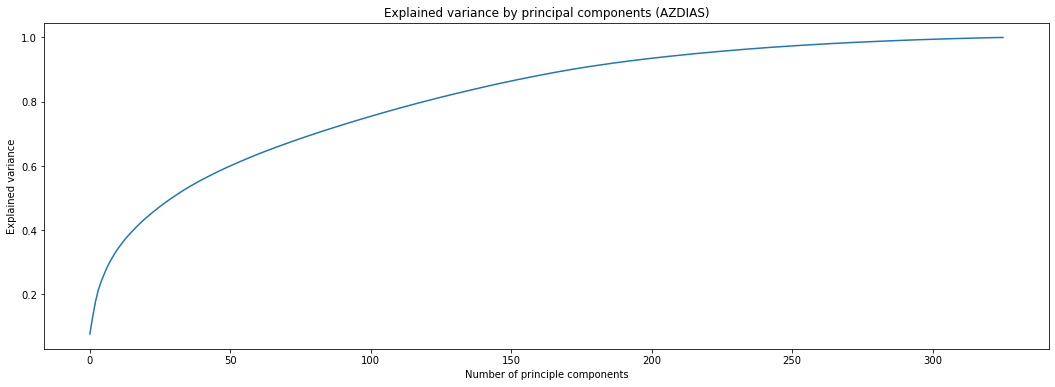

In [74]:
# plot explained variance on AZDIAS

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)
plt.figure(figsize=(18,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance by principal components (AZDIAS)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')

plt.show()

In [75]:
# perform eigendecomposition on covariance matrix

cov_mat_cus = np.cov(customers_scaled.T)

eig_vals_cus, eig_vecs_cus = np.linalg.eig(cov_mat_cus)

print('Eigenvectors \n%s' %eig_vecs_cus)
print('Eigenvalues \n%s' %eig_vals_cus)

Eigenvectors 
[[ 3.72421187e-05 -6.50256748e-04  3.54058790e-04 ...  1.42600115e-04
   6.39414643e-04  1.16797658e-04]
 [-3.18567995e-02  1.52487334e-02  2.64467866e-02 ...  7.11777147e-03
   4.68031929e-03  1.26039841e-03]
 [-8.40570340e-02  2.17994262e-02  1.73943632e-02 ...  9.31442051e-02
  -2.85509700e-01 -7.13809502e-02]
 ...
 [-4.80383127e-02  4.07069426e-02  2.63132610e-02 ... -6.29244531e-03
  -7.52640064e-04 -9.16414041e-03]
 [-2.43804483e-04 -1.89522921e-02 -1.30046477e-01 ...  1.05014693e-01
   1.58382936e-01 -4.26234901e-02]
 [ 2.92799751e-02 -6.40449448e-02 -4.20151588e-02 ... -1.41956869e-02
  -4.31984639e-03  2.71151333e-03]]
Eigenvalues 
[20.9797106  18.55427504 13.39947845  8.91504149  7.17773088  6.69539484
  6.33309807  5.6749331   4.8894193   4.67905178  4.33808044  4.09108427
  3.69041791  3.50840757  3.33216032  3.17233153  3.12936939  2.92958235
  2.85396097  2.73453864  2.70386035  2.59444802  2.5400137   2.49223875
  2.4606813   2.32244401  2.26152678  2.20034

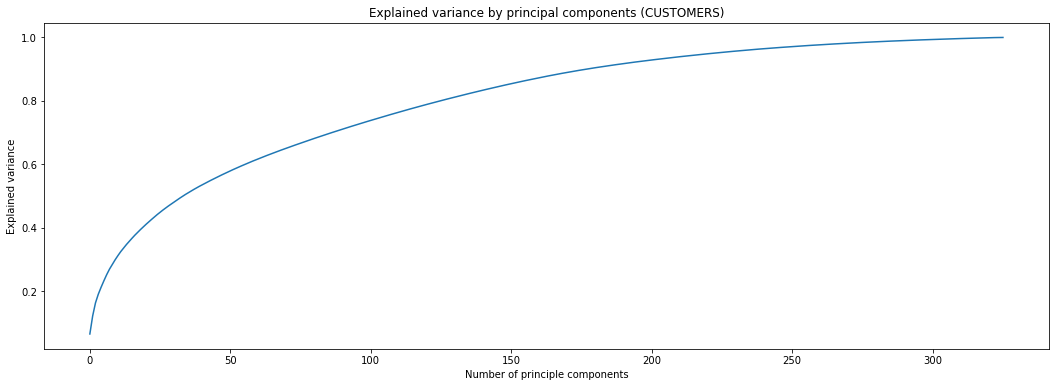

In [76]:
# plot explained variance on CUSTOMERS

pca = PCA()
customers_pca = pca.fit_transform(customers_scaled)

plt.figure(figsize=(18,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance by principal components (CUSTOMERS)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')

plt.show()

The two plots above display cumulative explained data variance by principle components.

We want to keep a small number of features while retaining high explained data variance. To decide how many top components to include, it's helpful to look at how much data variance the components capture. From the plots, we can conclude that 150 features can explain around 85% data variance. Let's check explained data variance by 160 principle components.

In [85]:
def reduce_dimension(df, n=160): 
    
    pca = PCA(n_components=n)
    
    df_160 = pca.fit_transform(df)
    df_160 = pd.DataFrame(df_160)
    
    print('Explained data variance by top 160 principal components is equal to ' 
          + str(pca.explained_variance_ratio_.sum())) 
    
    return pca, df_160

In [86]:
pca_azdias, azdias_pca_160 = reduce_dimension(azdias_scaled)

Explained data variance by top 160 principal components is equal to 0.8788451625006573


In [87]:
pca_customers, customers_pca_160 = reduce_dimension(customers_scaled)

Explained data variance by top 160 principal components is equal to 0.8691326467225284


In [88]:
azdias_pca_160.shape , customers_pca_160.shape

((737287, 160), (134246, 160))

Now, both of the two datasets have been reduced to only contain 160 principle components

## UNSUPERVISED TECH - SEGMENT CUSTOMERS - K-MEANS CLUSTERING

Reducing the number of dimensions follows clustering the general popilation into segments.

We want to select a k such that data points in a single cluster are close together but that there are enough clusters to effectively separate the data. After trying several values for k, the centroid distance typically reaches some "elbow"; it stops decreasing at a sharp rate and this indicates a good value of k.

In [89]:
def apply_kmeans(data, n_clusters):

    """
    Calculate the average within-cluster distance given a number of cluster
    """
    
    kmeans = KMeans(n_clusters=n_clusters)
    
    model = kmeans.fit(data)
    
    return abs(model.score(data))

In [94]:
%%time
within_cluster_distances =[]
for n_cluster in range(2, 21):
     within_cluster_distances.append(apply_kmeans(azdias_pca_160.sample(20000), n_cluster))

Wall time: 1min 8s


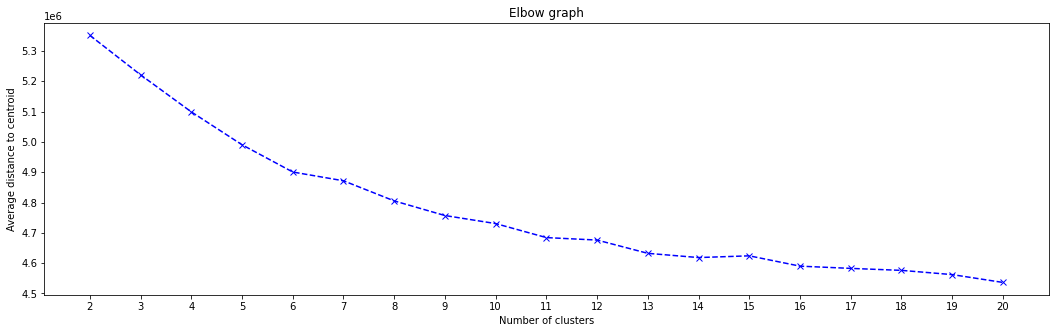

In [95]:
clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.figure(figsize=(18,5))
plt.plot(clusters, within_cluster_distances, \
        linestyle= "--",marker = "x", color="blue")
plt.xticks(ticks=clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance to centroid')
plt.title('Elbow graph')

plt.show()

From the elbow graph, we can see that within-cluster distances decrease at a high rate until reaching 11 clusters. This indicates that there is enough separation to distinguish the data points in each cluster, but also that we included enough clusters so that the data points aren’t extremely far away from each cluster. Thus, we come to the conclusion that 11 is the optimal number of clusters for AZDIAS.

In [109]:
n_clusters = 11

kmeans = KMeans(n_clusters=n_clusters)

**AZDIAS (general population)**

In [110]:
azdias_clusters = kmeans.fit_predict(azdias_pca_160)

In [111]:
azdias_clusters

array([4, 7, 6, ..., 7, 4, 6])

**CUSTOMERS (customer Base)**

In [112]:
customers_clusters = kmeans.fit_predict(customers_pca_160)

In [113]:
customers_clusters

array([6, 1, 9, ..., 7, 1, 4])

In [114]:
# save data
azdias_clustered = pd.DataFrame(azdias_clusters, columns = ['Kmeans_clusters'])
azdias_clustered.to_pickle('azdias_clustered.pkl')

customers_clustered = pd.DataFrame(customers_clusters, columns = ['Kmeans_clusters'])
customers_clustered.to_pickle('customers_clustered.pkl')

In [115]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = pd.Series(azdias_clusters).value_counts().sort_index()
cluster_info["Customer"] = pd.Series(customers_clusters).value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [116]:
cluster_info

,Cluster,Population,Customer
0,0,47173,9557
1,1,88128,14990
2,2,60640,3542
3,3,54057,9057
4,4,67074,11660
5,5,50431,10525
6,6,88834,19810
7,7,88094,16314
8,8,71793,15841
9,9,52893,17552


In [117]:
cluster_info['%General population'] = (cluster_info['Population'] / (cluster_info['Population'].sum()) * 100).round(2)
cluster_info['%Customer base'] = (cluster_info['Customer'] / (cluster_info['Customer'].sum()) * 100).round(2)

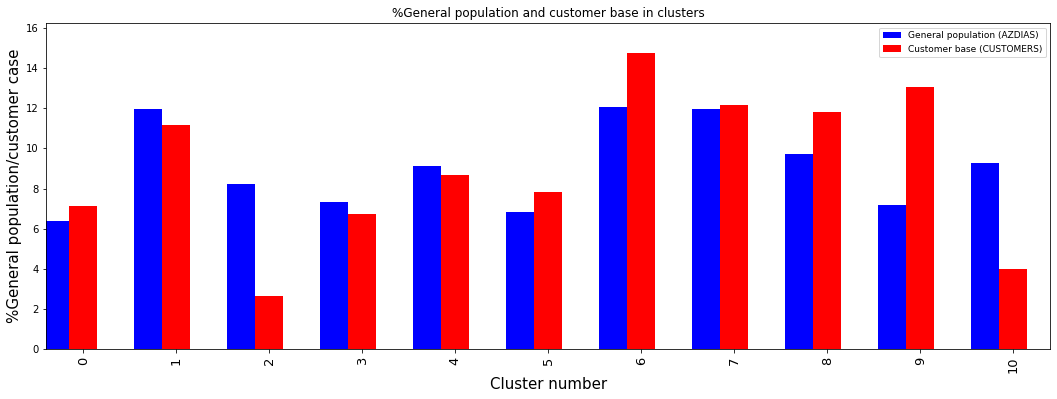

In [121]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot(111)

ax = cluster_info['%General population'].plot(x=cluster_info['Cluster'], \
                                                  width=-0.3, align='edge', \
                                                  color='blue', kind='bar', position=0)
ax = cluster_info['%Customer base'].plot(kind='bar', color='red', width = 0.3, align='edge', position=1)

ax.set_xlabel('Cluster number', fontsize=15) 
ax.set_ylabel('%General population/customer case', fontsize=15)

ax.xaxis.set(ticklabels=range(11))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('General population (AZDIAS)', 'Customer base (CUSTOMERS)'), fontsize=9)
plt.title(('%General population and customer base in clusters'))

plt.show()

We can clearly see in the above plot that some clusters are over represented by customers whereas others are not. This gives us an idea of better targetting future customers.

## SUPERVISED TECH

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [124]:
mailout_train = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [125]:
mailout_train.shape

(42962, 367)

### Deal with class imbalance in the train dataset

0    42430
1      532
Name: RESPONSE, dtype: int64


<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

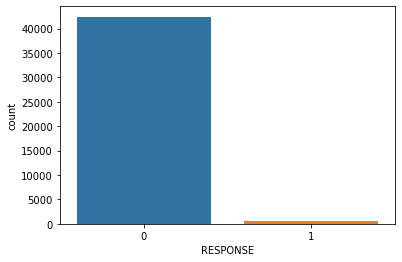

In [126]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train)

We can see that there's an imbalanced issue we need to deal with

In [127]:
customer_1 = mailout_train[mailout_train['RESPONSE']==1] 
customer_0 = mailout_train[mailout_train['RESPONSE']==0]

In [128]:
customer_1_balanced = resample(customer_1, replace=True, n_samples=42430, random_state=1)

In [129]:
# combined balance d data
mailout_train_balanced = pd.concat([customer_0, customer_1_balanced ])

In [130]:
print(mailout_train_balanced.RESPONSE.value_counts())

0    42430
1    42430
Name: RESPONSE, dtype: int64


In [131]:
# take the response column to be labels
labels = mailout_train_balanced['RESPONSE']

# drop the response column
mailout_train_balanced.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [132]:
# drop the LNR column
mailout_train_balanced.drop(['LNR'], axis=1, inplace=True)

In [133]:
# modify the clean_data function
def clean_train_data(df, attributes_values, columns_to_drop, corr_features):
    """
    Clean and prerpocess a dataframe
    - convert missing and unknown values to nan values
    - drop columns (features) with high %nan vlaues
    - drop rows with high %nan vlaues
    - re-encode categorical and mixed features
    - drop too highly correlated features
    - impute missing values
    
    INPUT
    - df (DataFrame): the DataFrame to be cleaned and preprocessed
    - attributes_values (DataFrame): the DataFrame to find unknown values for each feature
    - columns_to_drop (list): list of features to be droped due to high %nan values
    - corr_features (list): list of features that too highly correlate with other features
    
    OUTPUT
    - df_imputed (DataFrame): a cleaned and preprocessed DataFrame with nan values imputed
    """
    # convert missing and unknown values to nan values
    attributes_values = attributes_values[attributes_values.columns[1:]]
    attributes_values = attributes_values[attributes_values['Attribute'].notnull()]
    unknown = attributes_values[attributes_values['Meaning'].isin(['unknown', 'unknown / no main age detectable'])]

    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
        if column not in set(unknown['Attribute']):
            continue
        
        unknown_value = unknown.loc[unknown['Attribute'] == column].Value.item()
        unknown_value = set(float(x) for x in unknown_value.split(', ')) if type(unknown_value) is str else set([float(unknown_value)])
        df[column] = df[column].mask(df[column].isin(unknown_value), other=np.nan)
    
    
    

    df.drop(labels=columns_to_drop, axis=1, inplace=True)


    
    # treat 'X' and 'XX' as nan values
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    
    # re-encode binary categorical variables
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # drop multi-level categorical variables with more than 10 values
    df.drop(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis=1, inplace=True)
    
    # re-encode CAMEO_INTL_2015
    df['CAMEO_INTL_2015_WEALTH_LEVEL'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['CAMEO_INTL_2015_STATUS'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # re-encode LP_*
    df = encode_lp(df)
    
    # re-encode PRAEGENDE_JUGENDJAHRE
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_pj(x))
    
    # drop too highly correlated features
    df.drop(labels=set(df)&corr_features, axis=1, inplace=True)
    
    # impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df))
    
    return df_imputed

In [135]:
attributes_values = pd.read_excel('../DIAS Attributes - Values 2017.xlsx', header=1)

In [136]:
percent_missing_col_train = mailout_train_balanced.isnull().mean() * 100
columns_to_drop_train = percent_missing_col_train [percent_missing_col_train  > 20].index

In [137]:
corr_matrix_train = mailout_train_balanced.corr().abs().round(2)

corr_features_train = set()
for i in range(len(corr_matrix_train.columns)):
    for j in range(i):
        if abs(corr_matrix_train.iloc[i, j]) > 0.9:
            col = corr_matrix_train.columns[i]
            corr_features_train.add(col)

In [138]:
len(corr_features_train)

21

In [139]:
train = clean_train_data(mailout_train_balanced, attributes_values, columns_to_drop_train, corr_features_train)

In [140]:
print('TRAIN|Data shape (rows, cols): ', train.shape)
print()
train.head()

TRAIN|Data shape (rows, cols):  (84860, 270)



,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,267,268,269
0,2.0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,0.0,3.0,...,2.0,5.0,2.0,9.0,3.0,3.0,2.0,4.0,3.0,4.0
1,1.0,4.0,13.0,13.0,1.0,0.0,0.0,2.0,0.0,2.0,...,3.0,1.0,2.0,9.0,7.0,1.0,2.0,3.0,3.0,2.0
2,1.0,1.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,6.0,4.0,9.0,2.0,3.0,1.0,4.0,1.0,4.0
3,2.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,0.0,4.0,...,4.0,8.0,11.0,9.0,1.0,3.0,2.0,4.0,1.0,4.0
4,2.0,1.0,9.0,9.0,53.0,0.0,0.0,1.0,0.0,3.0,...,4.0,2.0,2.0,9.0,3.0,3.0,1.0,3.0,4.0,1.0


In [141]:
# scale features
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

### Test the performances of supervised machine learning algorithms
We have preprocessed the train dataset. Now we can choose from supervised machine learning models to train the training dataset.

The evaluation metric that we will be using is AUC for the ROC curve. 

A receiver operating characteristic (ROC) curve is a graphic plot used to display the true positive rate (TPR, known as recall, proportion of correctly labeled actual customers) against the false positive rate (FPR, proportion of non-customers labeled as customers).

Mathematical formulas of TPR and FPR are defined as:

TPR = TP / (TP + FN)

FPR = FP /(FP + TN)

where

TP = ture positive

FP = false postive

TN = true negative

FN = false negative

In [142]:
def train_classifier(classifier, param_grid, X=train, y=labels):
    """
    Fit a classifier using GridSearchCV, compute ROC AUC metric
    
    INPUT:
    - classifier (classifier): classifier to fit 
    - param_grid (dict): parameters of the classifier used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - AUROC score and elapsed time
    """
    start = time.time()
    
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    end = time.time()
    print('Time taken:', end-start)

    print('AUROC score:', grid.best_score_)
    
    return grid.best_estimator_

**a.Benchmark Model: Logistic Regression**

In [143]:
logistic_reg = LogisticRegression(random_state=10)

In [144]:
print(train_classifier(logistic_reg, {}))

Time taken: 15.302631616592407
AUROC score: 0.7869742508616179
LogisticRegression(random_state=10)


**b. RandomForestClssifier**

Random forest classifier creates a set of decision trees from randomly selected subset of training set. It then decide the final class of the test object by aggregating the votes from the decision trees.

In [145]:
random_forest_clf = RandomForestClassifier(random_state=10)

In [146]:
print(train_classifier(random_forest_clf, {}))

Time taken: 143.02382254600525
AUROC score: 0.9935088703585709
RandomForestClassifier(random_state=10)


**GradientBoostingClassifier**

In [147]:
gradient_boosting_clf = GradientBoostingClassifier(random_state=10)

In [148]:
print(train_classifier(gradient_boosting_clf, {}))

Time taken: 425.0988471508026
AUROC score: 0.9024049565159767
GradientBoostingClassifier(random_state=10)


**LightGBMClassifier**

Light GBM can handle the large size of data and takes lower memory to run. Another reason why Light GBM is so popular is because it focuses on accuracy of results.

In [155]:
lightgbm_clf = LGBMClassifier(random_state=10)

In [156]:
print(train_classifier(lightgbm_clf, {}))

Time taken: 15.292855739593506
AUROC score: 0.9874326898738097
LGBMClassifier(random_state=10)


**AdaBoostClassifier**

In [157]:
adaboost_clf = AdaBoostClassifier(random_state=10)

In [158]:
print(train_classifier(adaboost_clf, {}))

Time taken: 98.37448906898499
AUROC score: 0.818519529664114
AdaBoostClassifier(random_state=10)


**XGBClassifier**

In [161]:
xgb_clf = xgb.XGBClassifier(random_state=10)

In [162]:
print(train_classifier(xgb_clf, {}))

[13:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Based upon above results, I suspected that we have some overfitting because values of > 0.98 are very suspicious.  Maybe our resample techinique but be contribuiting to this.

Compared with the benchmark model, the GradientBoostingClassifier shows higher AUROC scores and took a fast time to train.

Thus, I decide to continue with the GradientBoostingClassifier algorithm with hyperparameters set as the following

**FIne tunning GradientBoostingClassifer**

In [163]:
gbc = GradientBoostingClassifier(random_state=10)

gbc_param_grid = {'loss': ['deviance'],
              'max_depth': [3],
              'learning_rate': [0.1],
              'n_estimators': [100],
              'random_state': [10]
             }

gbc_best_estimator = train_classifier(gbc, gbc_param_grid)

Time taken: 419.3621542453766
AUROC score: 0.9024049565159767


## Kaggle Competition
Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [164]:
mailout_test = pd.read_csv('../data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [166]:
print('TEST|Data shape (rows, cols): ', mailout_test.shape)
print()
mailout_test.head()

TEST|Data shape (rows, cols):  (42833, 366)



,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [167]:
# Copying LNR column
test_LNR = mailout_test['LNR']

mailout_test.drop(['LNR'], axis=1, inplace=True)

In [169]:
attributes_values = pd.read_excel('../DIAS Attributes - Values 2017.xlsx', header=1)

In [170]:
test = clean_train_data(mailout_test, attributes_values, columns_to_drop_train, corr_features_train)

In [171]:
# scale features
scaler = StandardScaler()

test = pd.DataFrame(scaler.fit_transform(test))

In [172]:
print('TEST|Data shape (rows, cols): ', test.shape)
print()
test.head()

TEST|Data shape (rows, cols):  (42833, 270)



,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,267,268,269
0,0.358149,-0.271646,-1.388820,-0.970957,-0.287584,-0.120872,-0.206929,-0.015838,-0.088595,-0.034350,...,1.627638,0.310496,0.532270,0.244893,-0.468790,0.178441,-1.213276,0.728696,-1.494812,-0.309375
1,0.358149,-0.271646,-0.275654,-2.481701,1.038302,-0.120872,-0.206929,-0.819601,-0.088595,1.024156,...,-1.245023,0.310496,-0.803958,0.244893,0.579374,0.178441,-1.213276,0.728696,0.025539,-1.829213
2,0.358149,4.719141,1.115804,0.287996,-0.287584,-0.120872,-0.206929,1.591688,-0.088595,1.024156,...,0.670084,1.674508,0.532270,0.244893,0.055292,0.178441,0.824215,0.728696,0.785714,-1.829213
3,0.358149,3.471445,-0.275654,-2.481701,-0.361244,-0.120872,-0.206929,-1.623364,-0.088595,1.024156,...,-0.287470,0.651499,0.532270,0.244893,-0.992871,0.178441,0.824215,0.728696,-1.494812,-0.309375
4,-1.414307,-0.271646,2.507261,0.791577,-0.361244,-0.120872,-0.206929,1.591688,-0.088595,-0.034350,...,-1.245023,-0.712513,-0.135844,0.244893,1.627537,1.070811,0.824215,0.728696,0.025539,-1.829213


### Classify the test dataset with the selected trained model

In [173]:
test_gbc_pred = gbc_best_estimator.predict_proba(test)

### CSV file for kaggle competition

In [175]:
kaggle = pd.DataFrame({'LNR':test_LNR.astype(np.int32), 'RESPONSE':test_gbc_pred[:, 1]})

kaggle.to_csv('kaggle.csv', index=False)

In [176]:
kaggle.head()

,LNR,RESPONSE
0,1754,0.705380
1,1770,0.709228
2,1465,0.181873
3,1470,0.065821
4,1478,0.127932


In [177]:
len(kaggle[kaggle['RESPONSE']>0.5])

9115

Among 42,833 individuals listed in the test dataset, 9,115 individuals are likely to become a customer of the maril-order company, which accounts for approximately 21% of the test individuals.